#### CS Final Project
#### Aditi Jha and Jungho Park
#### Customer Segmentation Using PCA and GMM


#### Loading Data and Importing Libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None) # showing all columns in the dataset

In [7]:
# Loading the dataset
data = pd.read_excel('Online_Retail.xlsx')

In [8]:
# Displaying the first few rows to understand the data
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [9]:
# creating a copy of the original data for backup:
data_original = data.copy()

#### Data Cleaning

In [10]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [11]:
# Dropping the Missing values:
data = data.dropna(subset=['CustomerID'])

In [13]:
# Dropping rows where Description is missing 
data = data.dropna(subset=['Description'])


In [14]:
# Verifying that there are no missing values in CustomerID and Description
print("Missing values after cleanup:\n", data.isnull().sum())


Missing values after cleanup:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [15]:
# Checking for duplicates:
duplicate_rows = data[data.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 5225


In [16]:
# Removing exact duplicates
data = data.drop_duplicates()


In [17]:
# Checking again for duplicates:
duplicate_rows = data[data.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 0


In [19]:
# Cleaned dataset data dimensions 
print("Shape of data after removing missing values and duplicates:", data.shape)

Shape of data after removing missing values and duplicates: (401604, 8)


#### Feature Engineering

We will create new features based on our existing features

In [20]:
# Creating a new column 'TotalSpend'
data['TotalSpend'] = data['Quantity'] * data['UnitPrice']

# Displaying the first few rows to check the new column
data[['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'TotalSpend']].head()


InvoiceNo StockCode  Quantity  UnitPrice  TotalSpend
0    536365    85123A         6       2.55       15.30
1    536365     71053         6       3.39       20.34
2    536365    84406B         8       2.75       22.00
3    536365    84029G         6       3.39       20.34
4    536365    84029E         6       3.39       20.34

Grouping the dataset by CustomerID to create customer-level features, such as:

PurchaseFrequency: Number of unique invoices.
TotalQuantity: Sum of quantities purchased.
TotalSpending: Sum of TotalSpend.
UniqueProducts: Number of unique products purchased.

In [21]:
# Aggregating data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',              # Purchase frequency
    'Quantity': 'sum',                   # Total quantity purchased
    'TotalSpend': 'sum',                 # Total amount spent
    'StockCode': 'nunique',              # Number of unique products purchased
    'Country': 'first'                   # Retain customer's country
}).rename(columns={
    'InvoiceNo': 'PurchaseFrequency',
    'Quantity': 'TotalQuantity',
    'TotalSpend': 'TotalSpending',
    'StockCode': 'UniqueProducts'
}).reset_index()

# Displaying the first few rows of the aggregated customer data
customer_data.head()


CustomerID  PurchaseFrequency  TotalQuantity  TotalSpending  \
0     12346.0                  2              0           0.00   
1     12347.0                  7           2458        4310.00   
2     12348.0                  4           2341        1797.24   
3     12349.0                  1            631        1757.55   
4     12350.0                  1            197         334.40   

   UniqueProducts         Country  
0               1  United Kingdom  
1             103         Iceland  
2              22         Finland  
3              73           Italy  
4              17          Norway

In [22]:
# Creating more features:
# Average Order Value (AOV):
customer_data['AverageOrderValue'] = customer_data['TotalSpending'] / customer_data['PurchaseFrequency']


In [23]:
# Average Quantity per purchase
customer_data['AvgQuantityPerPurchase'] = customer_data['TotalQuantity'] / customer_data['PurchaseFrequency']


In [24]:
# Product Variety Index:
# Measures the diversity of products purchased relative to the total quantity,  higher value indicates customers who buy a wide variety of items, while a lower value might suggest repeat purchases of similar items.

customer_data['ProductVarietyIndex'] = customer_data['UniqueProducts'] / customer_data['TotalQuantity']


In [25]:
customer_data.head()

CustomerID  PurchaseFrequency  TotalQuantity  TotalSpending  \
0     12346.0                  2              0           0.00   
1     12347.0                  7           2458        4310.00   
2     12348.0                  4           2341        1797.24   
3     12349.0                  1            631        1757.55   
4     12350.0                  1            197         334.40   

   UniqueProducts         Country  AverageOrderValue  AvgQuantityPerPurchase  \
0               1  United Kingdom           0.000000                0.000000   
1             103         Iceland         615.714286              351.142857   
2              22         Finland         449.310000              585.250000   
3              73           Italy        1757.550000              631.000000   
4              17          Norway         334.400000              197.000000   

   ProductVarietyIndex  
0                  inf  
1             0.041904  
2             0.009398  
3             0.115689  
4             0.086294

**Generating the most frequent words in the "Description" of products purchased columns, to understand which products are desired by the customers**:

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
# Downloading stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [29]:
# Extracting the 'Description' column
descriptions = data['Description'].dropna().str.lower()  # Converting to lowercase and removing NAs

# Defining stop words
stop_words = set(stopwords.words('english'))

# Additional stop words that might be relevant for this dataset
custom_stopwords = {'set', 'box', 'assorted', 'of', 'with', 'in', 'new', 'colour', 'pack', 'set2'}
stop_words.update(custom_stopwords)


In [31]:
# Converting stop_words set to a list
stop_words = list(stop_words)

# Initializing CountVectorizer with stop words as a list
vectorizer = CountVectorizer(stop_words=stop_words)
word_counts = vectorizer.fit_transform(descriptions)

# Summing up word occurrences
word_counts_sum = word_counts.sum(axis=0)
word_freq = [(word, word_counts_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)



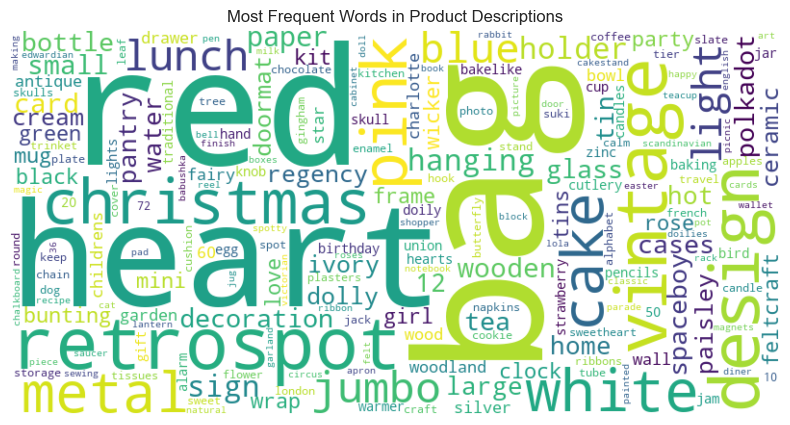

In [32]:
# Creating a word cloud for visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Product Descriptions")
plt.show()


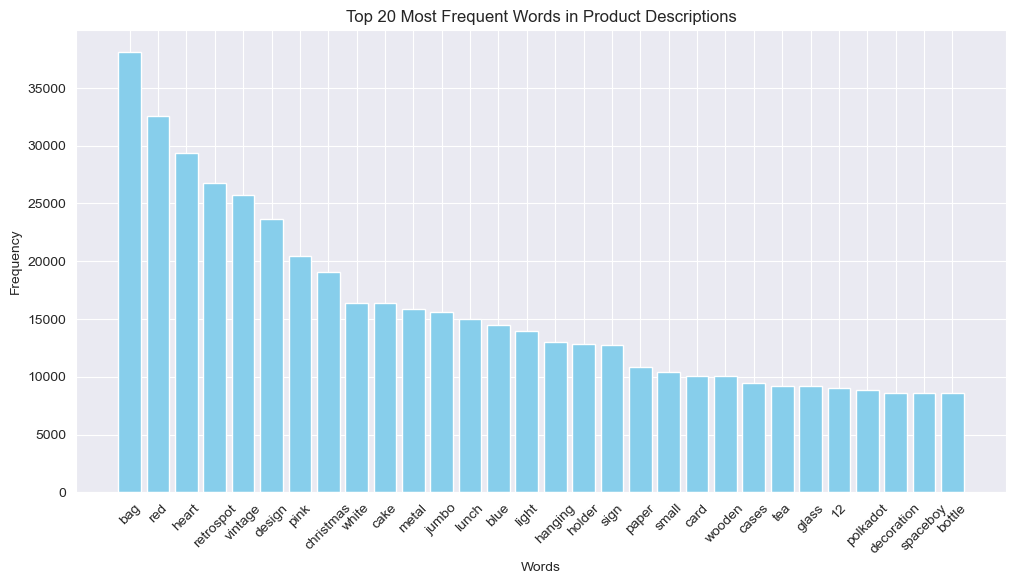

In [34]:
# Selecting the top 20 most frequent words
top_words = word_freq[:30]
words, counts = zip(*top_words)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Product Descriptions")
plt.xticks(rotation=45)
plt.show()


In [35]:
# Defining the top words to look for in descriptions
top_words = ['bag', 'red', 'heart', 'retrospot', 'vintage', 'design', 'pink',
             'christmas', 'white', 'cake', 'metal', 'jumbo', 'lunch', 'blue',
             'light', 'hanging', 'holder', 'sign', 'paper', 'small', 'card',
             'wooden', 'cases', 'tea', 'glass', '12', 'polkadot', 'decoration',
             'spaceboy', 'bottle']

# Initializing binary columns for each top word in the original data
for word in top_words:
    data[word] = data['Description'].str.contains(word, case=False, na=False).astype(int)

# Aggregating to customer level by taking the maximum for each word column
# If a customer has bought any product with that word, the value will be 1
word_features = data.groupby('CustomerID')[top_words].max().reset_index()

# Merging these features back into the customer_data DataFrame
customer_data = customer_data.merge(word_features, on='CustomerID', how='left')

# Displaying the first few rows to verify
customer_data.head()


CustomerID  PurchaseFrequency  TotalQuantity  TotalSpending  \
0     12346.0                  2              0           0.00   
1     12347.0                  7           2458        4310.00   
2     12348.0                  4           2341        1797.24   
3     12349.0                  1            631        1757.55   
4     12350.0                  1            197         334.40   

   UniqueProducts         Country  AverageOrderValue  AvgQuantityPerPurchase  \
0               1  United Kingdom           0.000000                0.000000   
1             103         Iceland         615.714286              351.142857   
2              22         Finland         449.310000              585.250000   
3              73           Italy        1757.550000              631.000000   
4              17          Norway         334.400000              197.000000   

   ProductVarietyIndex  bag  red  heart  retrospot  vintage  design  pink  \
0                  inf    0    0      0          0        0       0     0   
1             0.041904    1    1      1          1        1       1     1   
2             0.009398    0    1      1          1        1       1     1   
3             0.115689    1    1      1          1        1       1     1   
4             0.086294    1    1      0          1        1       0     1   

   christmas  white  cake  metal  jumbo  lunch  blue  light  hanging  holder  \
0          0      0     0      0      0      0     0      0        0       0   
1          1      1     1      1      0      0     1      1        0       1   
2          1      0     1      0      0      0     1      0        0       0   
3          1      1     1      1      0      0     1      1        1       1   
4          0      0     0      1      0      0     1      0        0       0   

   sign  paper  small  card  wooden  cases  tea  glass  12  polkadot  \
0     0      0      0     0       0      0    0      0   0         0   
1     1      0      1     1       1      1    1      1   0         1   
2     1      1      0     0       0      1    1      0   1         0   
3     1      1      1     0       1      1    1      1   1         1   
4     1      0      0     0       0      0    1      0   0         1   

   decoration  spaceboy  bottle  
0           0         0       0  
1           1         1       0  
2           0         0       0  
3           1         0       0  
4           0         1       0

**So, We created total of 37 more columns (new variables showing characteristics of customer and their purchases):** PurchaseFrequency, TotalQuantity, TotalSpending, UniqueProducts, AverageOrderValue, AvgQuantityPerPurchase, ProductVarietyIndex, 30 variables showing 30 most frequent used words.

#### Data Preprocessing

In [36]:
# Extracting column names for standardization:
column_names = customer_data.columns

# Displaying the column names
print("Column Names:", column_names)


Column Names: Index(['CustomerID', 'PurchaseFrequency', 'TotalQuantity', 'TotalSpending',
       'UniqueProducts', 'Country', 'AverageOrderValue',
       'AvgQuantityPerPurchase', 'ProductVarietyIndex', 'bag', 'red', 'heart',
       'retrospot', 'vintage', 'design', 'pink', 'christmas', 'white', 'cake',
       'metal', 'jumbo', 'lunch', 'blue', 'light', 'hanging', 'holder', 'sign',
       'paper', 'small', 'card', 'wooden', 'cases', 'tea', 'glass', '12',
       'polkadot', 'decoration', 'spaceboy', 'bottle'],
      dtype='object')


In [39]:
# Replacing inf and -inf values in ProductVarietyIndex with the column median
customer_data['ProductVarietyIndex'] = customer_data['ProductVarietyIndex'].replace([np.inf, -np.inf], customer_data['ProductVarietyIndex'].median())

# Dropping rows where ProductVarietyIndex has inf or -inf values
customer_data = customer_data.replace([np.inf, -np.inf], np.nan)
customer_data = customer_data.dropna(subset=['ProductVarietyIndex'])

# List of columns to standardize (excluding CustomerID and Country)
columns_to_standardize = [
    'PurchaseFrequency', 'TotalQuantity', 'TotalSpending', 'UniqueProducts',
    'AverageOrderValue', 'AvgQuantityPerPurchase', 'ProductVarietyIndex',
    'bag', 'red', 'heart', 'retrospot', 'vintage', 'design', 'pink',
    'christmas', 'white', 'cake', 'metal', 'jumbo', 'lunch', 'blue',
    'light', 'hanging', 'holder', 'sign', 'paper', 'small', 'card',
    'wooden', 'cases', 'tea', 'glass', '12', 'polkadot', 'decoration',
    'spaceboy', 'bottle'
]

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler on the columns to standardize and transform the data
customer_data[columns_to_standardize] = scaler.fit_transform(customer_data[columns_to_standardize])

# Displaying the first few rows to verify
customer_data.head()

CustomerID  PurchaseFrequency  TotalQuantity  TotalSpending  \
0     12346.0          -0.329362      -0.239517      -0.230420   
1     12347.0           0.206102       0.286544       0.294055   
2     12348.0          -0.115176       0.261504      -0.011717   
3     12349.0          -0.436455      -0.104470      -0.016547   
4     12350.0          -0.436455      -0.197355      -0.189727   

   UniqueProducts         Country  AverageOrderValue  AvgQuantityPerPurchase  \
0       -0.704922  United Kingdom          -0.871620               -0.611002   
1        0.489243         Iceland           0.834839                0.484297   
2       -0.459064         Finland           0.373647                1.214533   
3        0.138018           Italy           3.999448                1.357239   
4       -0.517602          Norway           0.055173                0.003488   

   ProductVarietyIndex       bag       red     heart  retrospot   vintage  \
0            -0.183716 -1.192544 -1.782061 -1.739478  -1.437330 -1.549093   
1            -0.449361  0.838544  0.561148  0.574885   0.695734  0.645539   
2            -0.633245 -1.192544  0.561148  0.574885   0.695734  0.645539   
3            -0.031965  0.838544  0.561148  0.574885   0.695734  0.645539   
4            -0.198249  0.838544  0.561148 -1.739478   0.695734  0.645539   

     design      pink  christmas     white      cake     metal     jumbo  \
0 -1.396448 -1.406486  -1.077565 -1.273225 -1.276316 -0.970250 -0.769879   
1  0.716102  0.710992   0.928018  0.785407  0.783505  1.030662 -0.769879   
2  0.716102  0.710992   0.928018 -1.273225  0.783505 -0.970250 -0.769879   
3  0.716102  0.710992   0.928018  0.785407  0.783505  1.030662 -0.769879   
4 -1.396448  0.710992  -1.077565 -1.273225 -1.276316  1.030662 -0.769879   

      lunch      blue     light   hanging    holder      sign     paper  \
0 -0.692478 -1.195926 -1.322757 -1.070651 -1.114990 -1.598271 -1.003666   
1 -0.692478  0.836172  0.755997 -1.070651  0.896869  0.625676 -1.003666   
2 -0.692478  0.836172 -1.322757 -1.070651 -1.114990  0.625676  0.996347   
3 -0.692478  0.836172  0.755997  0.934011  0.896869  0.625676  0.996347   
4 -0.692478  0.836172 -1.322757 -1.070651 -1.114990  0.625676 -1.003666   

      small      card    wooden     cases       tea     glass        12  \
0 -1.068685 -0.958324 -1.004126 -0.771764 -1.190858 -0.935730 -0.920361   
1  0.935730  1.043488  0.995891  1.295732  0.839731  1.068685 -0.920361   
2 -1.068685 -0.958324 -1.004126  1.295732  0.839731 -0.935730  1.086531   
3  0.935730 -0.958324  0.995891  1.295732  0.839731  1.068685  1.086531   
4 -1.068685 -0.958324 -1.004126 -0.771764  0.839731 -0.935730 -0.920361   

   polkadot  decoration  spaceboy    bottle  
0 -0.792275   -0.880791 -0.771764 -0.806495  
1  1.262189    1.135344  1.295732 -0.806495  
2 -0.792275   -0.880791 -0.771764 -0.806495  
3  1.262189    1.135344 -0.771764 -0.806495  
4  1.262189   -0.880791  1.295732 -0.806495

#### Principal Component Analysis (PCA) Implementation


In [40]:
from sklearn.decomposition import PCA

# Defining the number of components (initially using all components to check variance)
pca = PCA(n_components=len(columns_to_standardize))

# Fitting PCA on the standardized data
pca.fit(customer_data[columns_to_standardize])

# Getting the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Displaying the explained variance ratios
print("Explained variance by each component:\n", explained_variance)


Explained variance by each component:
 [0.28255725 0.07426313 0.06591686 0.03863889 0.03328069 0.03234563
 0.02874933 0.02695319 0.02446668 0.02396404 0.02250836 0.02213831
 0.020462   0.01961333 0.01854331 0.01813349 0.01729454 0.01689725
 0.01568379 0.01563591 0.01505929 0.01492627 0.0146355  0.01382733
 0.01337552 0.01324402 0.01281084 0.01261295 0.01174674 0.01102079
 0.01024661 0.01013958 0.00961726 0.0087673  0.00528086 0.00288606
 0.0017571 ]


**Plotting Cumulative explained variance**

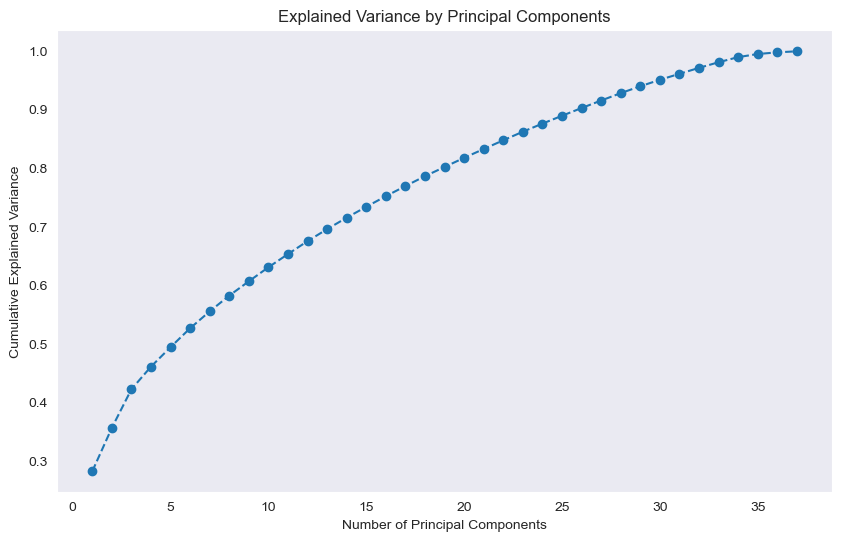

In [41]:

# Calculating cumulative explained variance
cumulative_variance = explained_variance.cumsum()

# Plotting cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()


In [44]:
# PCA with 25 components based on the cumulative explained variance
n_components = 25
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(customer_data[columns_to_standardize])

# Creating a DataFrame with the top 25 principal components
pca_data = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Adding CustomerID back to the PCA data for reference
pca_data['CustomerID'] = customer_data['CustomerID']

# Displaying the first few rows of the transformed data
pca_data.head()


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -6.295435  0.575237  0.199508 -1.214255  0.492761 -0.031506 -0.033481   
1  3.071044  0.183188  0.231803  1.017991 -0.160222  0.446609 -0.239639   
2 -0.650727  1.778483 -1.918185  1.923772  1.295166  2.268400 -0.353923   
3  3.464336  0.355171  0.797628  3.765836 -0.475131  0.006753 -1.224285   
4 -1.991780  1.273870 -2.421382 -0.408074 -1.520294 -0.146492  0.090059   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.221739  0.570275  0.587668 -0.019623 -0.179516  0.057175  0.016519   
1 -0.273549 -0.801445  0.378768  0.115461 -0.952353  0.225537  0.388063   
2  0.874859 -1.210669 -0.940000  0.036811  0.621298 -0.416734 -0.880144   
3  1.123903 -0.331960  0.345346 -0.115947 -0.122263 -0.772402  0.223003   
4  0.230397 -0.591817 -0.183057  1.082386 -1.626184 -0.940569  0.610117   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0 -0.113381  0.093945  0.219982  0.081245 -0.212915  0.089439  0.039151   
1 -1.341928 -0.477695 -1.574851 -0.235973  0.451920 -0.668529  1.136141   
2 -0.320742  0.718399  0.243844 -0.852517  0.151254  0.071779 -0.992620   
3 -1.560365  0.207710  0.126541  0.262114 -0.566602 -0.454305 -0.885125   
4 -1.222465 -0.924883 -0.049794 -1.714356  1.170175 -0.080539 -0.175999   

       PC22      PC23      PC24      PC25  CustomerID  
0  0.172250 -0.289903 -0.113519  0.088350     12346.0  
1  1.510228  0.490156 -0.018290  0.165412     12347.0  
2 -0.539038  0.264099  0.679976  0.341362     12348.0  
3 -0.045127  0.076587  0.399031  0.629638     12349.0  
4  0.113442  0.166731  0.118876 -0.953301     12350.0

**Scatter Plot of the first two principal components**

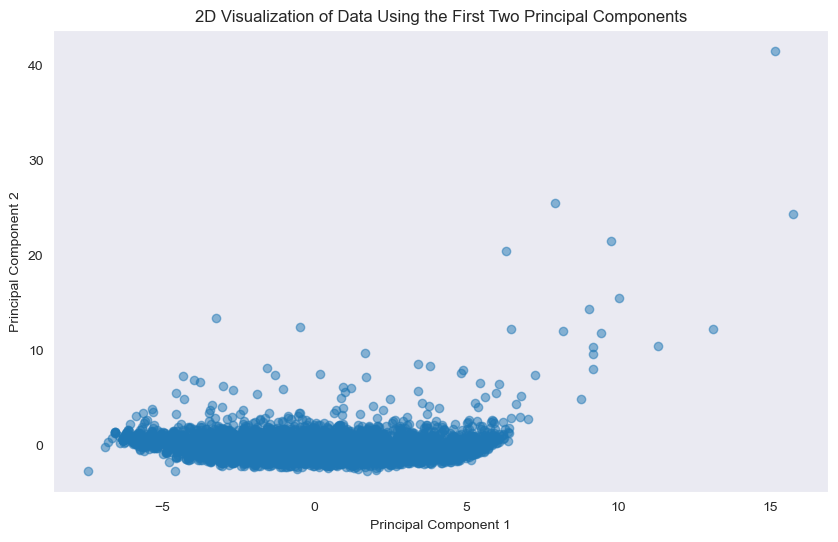

In [45]:
# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_data['PC1'], pca_data['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Data Using the First Two Principal Components')
plt.grid()
plt.show()


Here, the data has a tighter spread near the x-axis, which may imply that the majority of the variance is concentrated along PC1, while PC2 adds less distinctive spread. Most data points form a dense cluster, implying that a large group of customers have similar behaviors or characteristics.  The points further away from the cluster might indicate outliers or unique customer segments.

**Scree Plot of Explained variance by Principal components**

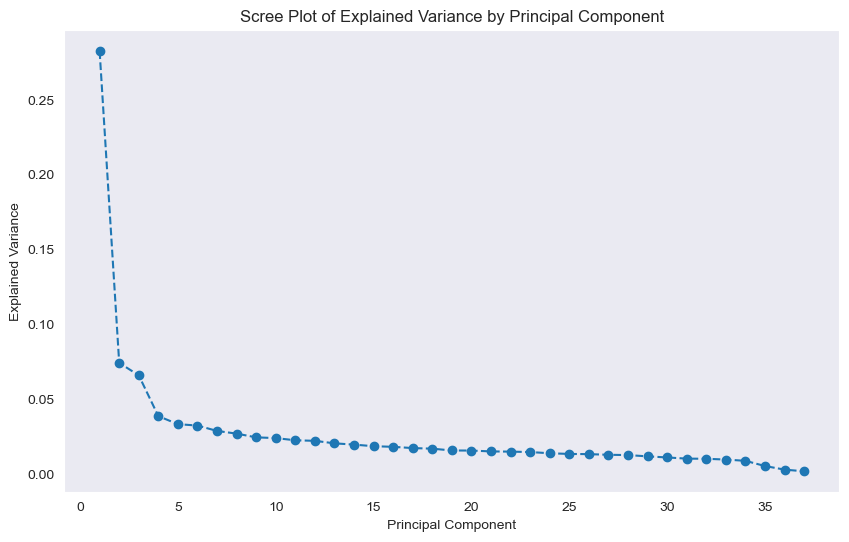

In [46]:
# Scree plot of explained variance by principal components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Scree Plot of Explained Variance by Principal Component')
plt.grid()
plt.show()


A scree plot visualizes the explained variance of each principal component. It can help confirm the number of principal components that capture most of the variance. The above plot shows that the first few components capture the majority of variance, with diminishing returns after around 5 components. We selected 25 components, which captures most of the data's structure.

**Pair Plot of the First Few Principal Components**

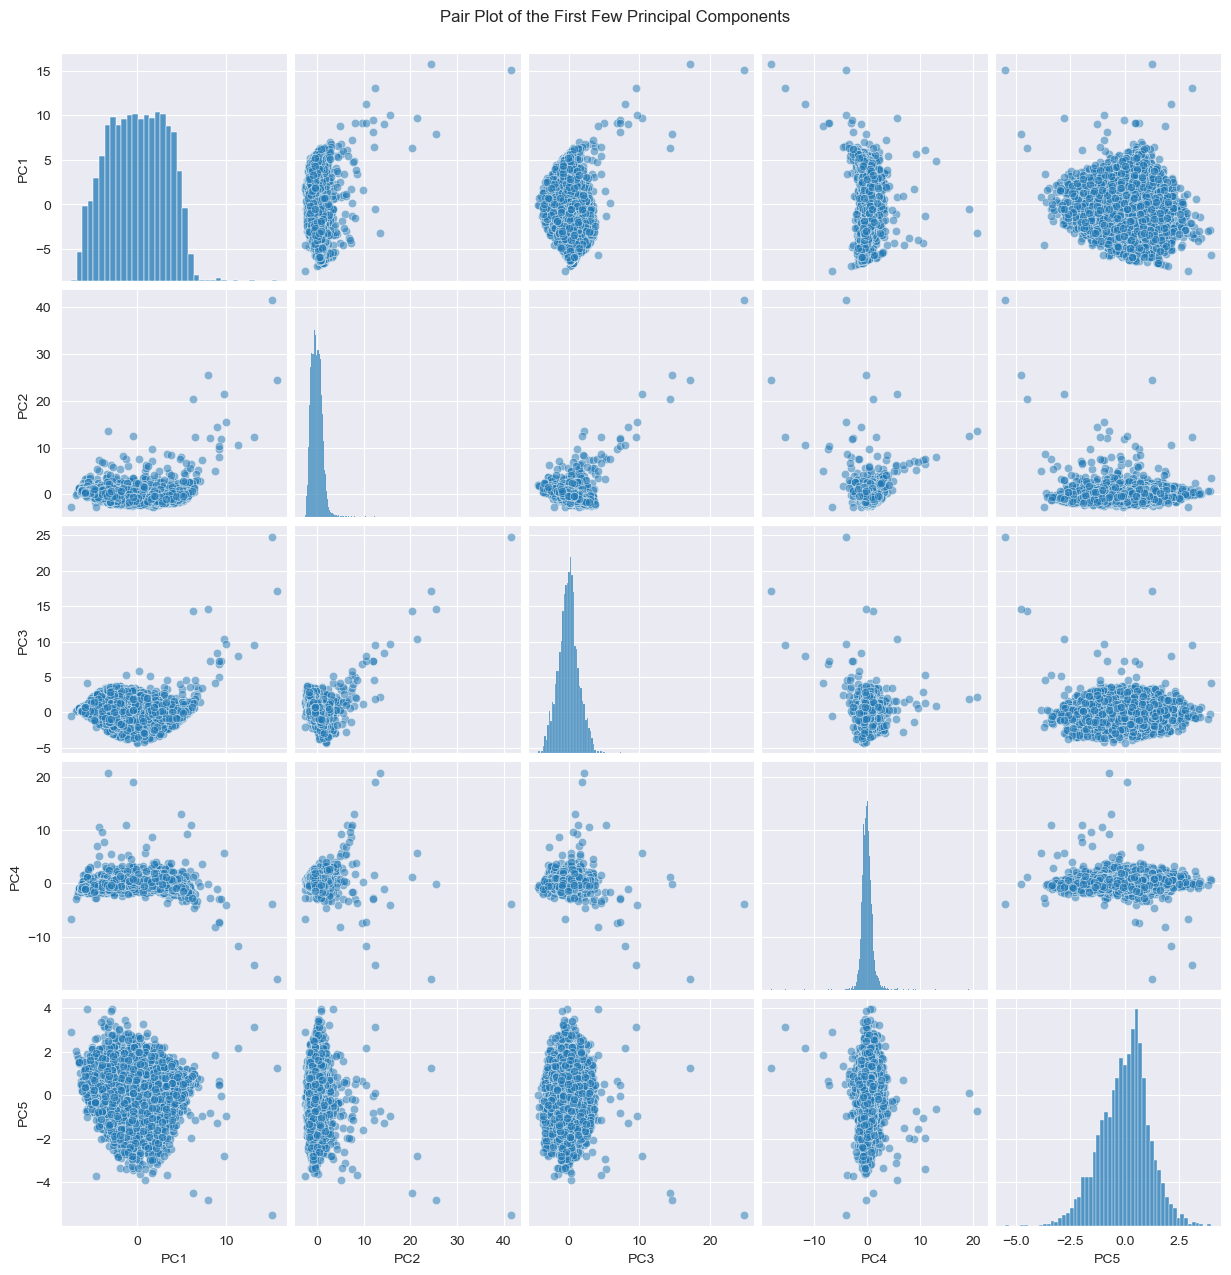

In [47]:

# Selecting the first few principal components
pca_df = pca_data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

# Plotting pairplot for the first few principal components
sns.pairplot(pca_df, plot_kws={'alpha':0.5})
plt.suptitle('Pair Plot of the First Few Principal Components', y=1.02)
plt.show()


The above plot is showing the pairwise relationships among the first 5 components. There are some overlapping and distinct groupings, which could hint at potential clusters or customer patterns.

**Heatmap of Principal Component Loadings**

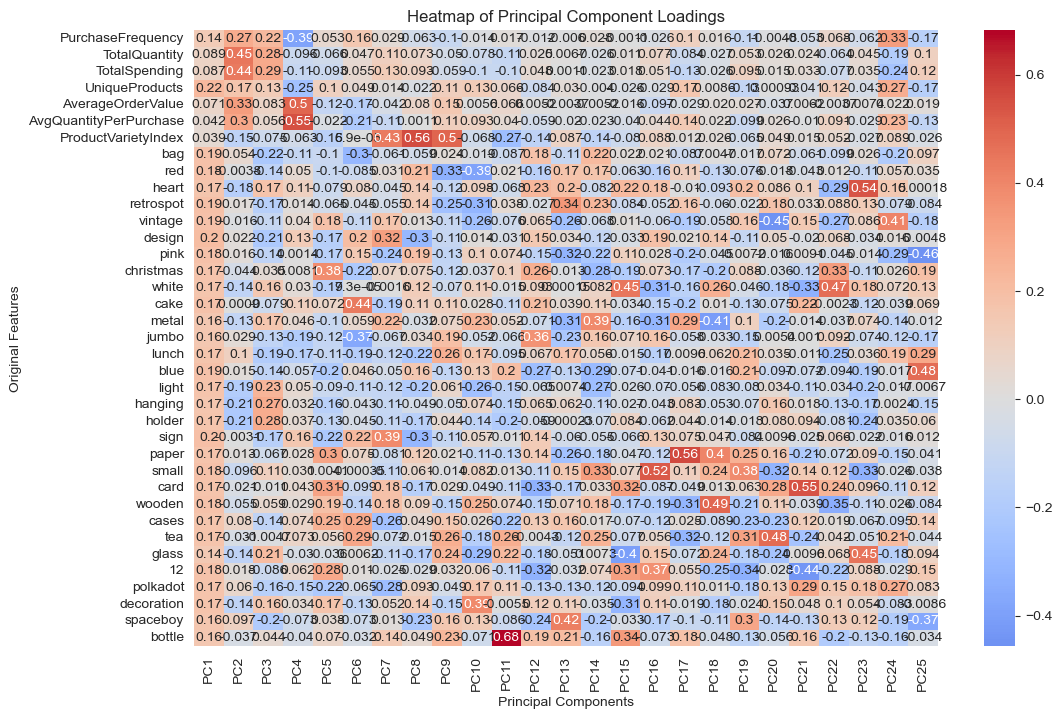

In [48]:
# Loadings are the coefficients that map each feature to the principal components
loadings = pca.components_.T
loading_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(n_components)], index=columns_to_standardize)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(loading_df, annot=True, cmap='coolwarm', center=0)
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.title('Heatmap of Principal Component Loadings')
plt.show()


The above heatmap indicates how much each original feature contributes to each principal component. Specific features (like TotalSpending and PurchaseFrequency) heavily influence some components, helping explain what each component represents.

**3D Scatter Plot of the First Three Principal Components**

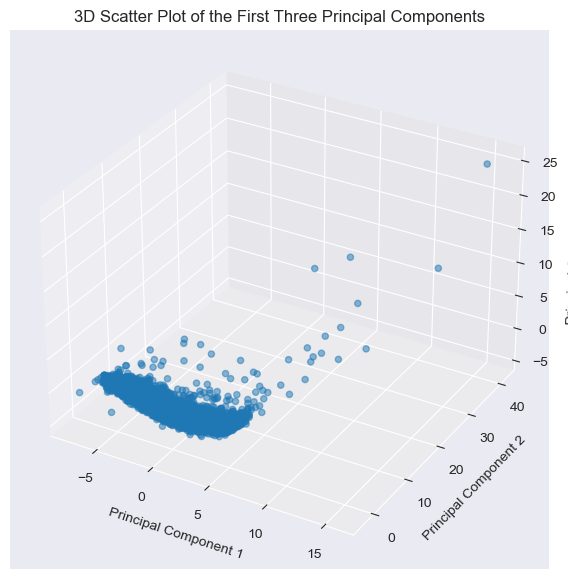

In [49]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Scatter Plot of the First Three Principal Components')
plt.show()


The above is a 3D visualization showing relationships across the first three components. The above plot highlights the concentration of data in a central cluster, with some outliers or dispersed points, which may be useful for identifying segments with GMM.

#### Gaussian Mixture Model For Clustering